In [60]:
import numpy as np
from functools import partial
import sobol_seq
import re
import matplotlib.pyplot as plt

**Problem 1 Pak Kun**

In [61]:
def objective_function(x):
    f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])
    f2 = (x[0]*x[1])**2-np.cos(x[0]+x[1])
    return np.array([f1,f2])

dim = 2
boundaries = np.array([(-10,10) for _ in range (dim)])
mutation_factor=0.5
crossover_rate=0.5
num_l=20
theta=-1+1e-3
tau_d=0.4
s_max=100
print_gen=True
Hm = 50

m_cluster = s_max
gamma = -0.2
epsilon = 10**(-3)
delta = 0.01
k_cluster = 10
m = 100
k_max = 200

# Objective Function

In [62]:
def root_objective_function(x:np.ndarray):
    res = 0
    F_array = objective_function(x)
    for f in F_array:
        res += np.abs(f)
    return -1/(1+res)

In [63]:
"""Characteristic Function"""
def chi_p(delta_j, rho):
    return 1 if delta_j <= rho else 0

"""Repulsion Function"""
def repulsion_function(x,
                       archive,
                       objective_func=root_objective_function,
                       beta=100,
                       rho=1e-8):
    f_x = objective_func(x)
    Rx = 0
    for x_star in archive:
        delta_j = np.linalg.norm(x-x_star)
        Rx += np.exp(-delta_j) * chi_p(delta_j, rho)
    Rx *= beta
    Rx += f_x
    return Rx

"""Fitness Function"""
def fitness_function(x,
                     archive,
                     objective_func=root_objective_function,
                     repulsion_func=repulsion_function):
    f_x = objective_func(x)
    if archive == []:
        return f_x
    else:
        return repulsion_func(x,archive)
    
# # Test the Functiuons
# arch = [np.array([1,2]),np.array([3,4]),np.array([-6.43,0.15])]
# x = np.array([-6.437160,0.155348])
# print(fitness_function(x,
#                        arch,
#                        objective_func=root_objective_function,
#                        repulsion_func=partial(repulsion_function,
#                                               objective_func = root_objective_function,
#                                               beta=1000,rho=0.01)))

In [64]:
"""GENERATE POINTS USING SOBOL SEQUENCE"""
def generate_points(dim: int,
                    npoint:int,
                    low=-10,
                    high=10,
                    sobol = True):
    if type(low) != type(high):
        raise TypeError('The type of "low" and "high" should be the same.')
    if type(low) == int:
        boundaries = [(low,high) for _ in range (dim)]
    elif type(low) == list or type(low) == np.ndarray:
        if len(low) != len(high):
            raise TypeError('The length of "low" and "high" should be the same.')
        else:
            boundaries = [(low[i],high[i]) for i in range (len(low))]

    if sobol == True:
        # Generate Sobol sequence points
        sobol_points = sobol_seq.i4_sobol_generate(dim, npoint)
        # Scale the Sobol points to fit within the specified boundaries
        scaled_points = []
        for i in range(dim):
            a, b = boundaries[i]
            scaled_dim = a + sobol_points[:, i] * (b - a)
            scaled_points.append(scaled_dim)
        # Transpose the scaled points to get points per dimension
        scaled_points = np.array(list(map(list, zip(*scaled_points))))
    
    else:
        scaled_points = np.zeros((npoint, dim))
        for i in range(dim):
            min_val, max_val = boundaries[i]
            scaled_points[:, i] = np.random.uniform(min_val, max_val, npoint)

    return scaled_points

# def initialize_population(pop_size, dimensions, bounds):
#     population = np.random.rand(pop_size, dimensions)
#     lower_bounds, upper_bounds = np.asarray(bounds).T
#     diff = np.fabs(lower_bounds - upper_bounds)
#     return lower_bounds + population * diff

In [65]:
# Mutation function for DE
def mutate(population, F):
    # Vectorized mutation operation
    indices = np.arange(population.shape[0])
    np.random.shuffle(indices)
    r1, r2, r3 = population[indices[:3]]
    mutant = r1 + F * (r2 - r3)
    return mutant

def crossover(target, mutant, CR):
    cross_points = np.random.random(target.shape) < CR
    # Ensure at least one true crossover point
    if not np.any(cross_points):
        cross_points[np.random.randint(0, target.shape[0])] = True
    trial = np.where(cross_points, mutant, target)
    return trial

def mutation_penalty(x_i, subpop_i, boundaries, scaling_factor):
    """GENERATE: three distinct individuals xr1, xr1, xr1 from the current population randomly"""
    subpop_i_copy = subpop_i.copy()
    pop_ids = np.arange(subpop_i_copy.shape[0])
    indices_to_delete = np.where(np.all(subpop_i_copy == x_i, axis=1))[0] # Ensure that x_i is excluded from the selected subpopulation
    subpop_ids_no_i = np.delete(pop_ids, indices_to_delete, axis=0)
    subpop_i_copy = subpop_i_copy[subpop_ids_no_i]

    """MUTATION: Form the donor/mutation vector"""
    dv_i = mutate(subpop_i_copy,scaling_factor)

    """Set penalty for every donor vector that violates the boundaries"""
    for j in range (len(dv_i)):
        if dv_i[j] < boundaries[j,0]:
            dv_i[j] = (x_i[j]+boundaries[j,0])/2
        elif dv_i[j] > boundaries[j,1]:
            dv_i[j] = (x_i[j]+boundaries[j,1])/2
    return dv_i


In [66]:
"""FInd the closest points in a set to an initial point"""
def closest_solution(initial_point,set_of_points):
    diff = set_of_points-initial_point
    distances = np.linalg.norm(diff,axis=1)
    id_min_dist = np.argmin(distances)
    return id_min_dist,set_of_points[id_min_dist]

# # test the function
# alpha = np.array([1, 1])
# B = np.array([[5, 2],
#               [3, 4],
#               [5, 5]])
# closest_solution(alpha,B)

In [67]:
"""Calculate Euclidean distances and select t closest individuals"""
def subpopulating(individual, 
                  population, 
                  t,
                  return_index = False,
                  show_distances = False): 
    """Input"""
    # individual
    # population
    # t: max number of units in a subpopulation

    """Algorithm"""
    # Calculate the Euclidean distances from the individual to all others in the population
    distances = np.sqrt(np.sum((population - individual) ** 2, axis=1))
    # Get the indices of the individuals with the smallest distances
    closest_indices = np.argsort(distances)[:t]
    # Form the subpopulation with the closest individuals
    subpop = population[closest_indices]

    if show_distances == True:
        print(f'Distance: \n{distances[:t]}')
    if return_index == True:
        if t == 1:
            return closest_indices,subpop.flatten()
        else:
            return closest_indices,subpop
    else:
        if t == 1:
            return subpop.flatten()
        else:
            return subpop

# # Test the function
# # Assuming P is a numpy array of individuals where each individual is a point in n-dimensional space
# np.random.seed(0)
# P = np.random.rand(100, 2)  # Example: 100 individuals in a 2-dimensional space
# # print(f"P:{P}")
# print("")

# # The number of individuals to select with the smallest Euclidean distances
# t = 2
# # Forming subpopulations for each individual in P
# subpopulations = [subpopulating(xi, P, t) for xi in P]
# # print(f"subpopulations:{subpopulations}")
# print("")

# # Now subpopulations is a list of numpy arrays, each containing the t closest individuals to each xi in P (including xi itself)
# # For example, to access the subpopulation for the first individual in P:
# subpopulation_first_individual = subpopulations[0]
# print(f"subpopulation_first_individual:{subpopulation_first_individual}")

# [id1,id2],[v1,v2] = subpopulating(P[0],P,t,show_distances=True,return_index=True)
# v1,v2

In [68]:
def update_archive(x: np.ndarray,
                   objective_function,
                   archive,
                   theta,
                   tau_d,
                   s_max):
    """Input"""
    # x : Individual
    # theta : accuracy level
    # tau_d : distance radius
    # s_max : maximum archive size
    # archive : archive
    # s : archive current size

    f_x = objective_function(x)
    s = len(archive) # archive current size
    if f_x < theta: # x is a root
        # print(f'f({x})= {f_x}')
        if s == 0: # archive is empty
            archive.append(x)
            s+=1
        else:
            """Find the closest solution x_prime ∈ archive to x in the decision space"""
            dist_min = np.linalg.norm(x-archive[0])
            idx_min = 0
            x_prime= archive[idx_min]
            for i in range(1,len(archive)): 
                dist = np.linalg.norm(x-archive[i])
                if dist < dist_min:
                    dist_min = dist
                    x_prime = archive[i]
                    idx_min = i
            f_x_prime = root_objective_function(x_prime)
            if dist_min < tau_d: # x and x_prime are too close
                if f_x < f_x_prime:
                    x_prime = x
                    archive[idx_min] = x_prime
            else:
                if s < s_max:
                    archive.append(x)
                    s += 1
                else:       # archive is full
                    if f_x<f_x_prime:
                        x_prime = x
                        archive[idx_min] = x_prime
    return archive


# # Test the function
# x = np.array([-6.437160,0.155348]) # Individual
# theta = 1e-4 # accuracy level
# tau_d = 1e-1 # distance radius
# s_max = 3 # maximum archive size
# archive = [np.array([0,0]),np.array([1,2]),np.array([-6.4,0])] # archive
# update_archive(x,root_objective_function,archive,theta,tau_d,s_max)

In [69]:
def update_parameter(M_F,
                     M_CR,
                     Hm:int):
    """Input"""
    # MF: Historical memories of scaling factor of DE as F
    # MCR:Historical memories crossover rate of DE as CR
    # Hm: Size of Historical Memories

    # Randomly select an index
    hi = np.random.randint(0, Hm)
    # Generate Fi using the Cauchy distribution with the location parameter MF[hi] and scale 0.1
    Fi = np.random.standard_cauchy() * 0.1 + M_F[hi]
    # Generate CRi using the Gaussian distribution with mean MCR[hi] and standard deviation 0.1
    CRi = np.random.normal(M_CR[hi], 0.1)
    # Ensure CRi is within the range [0, 1] and Fi is within the range [0,1]
    Fi = np.clip(Fi, 0, 1)
    CRi = np.clip(CRi, 0, 1)
    return Fi, CRi

# # Coba
# MF = [0.5, 0.6, 0.7, 0.8, 0.9] 
# MCR = [0.1, 0.2, 0.3, 0.4, 0.5]
# update_parameter(MF,MCR,len(MF))

In [70]:
def meanWL(elements, weights):
    """
    Calculate the weighted Lehmer mean of elements.
    Lehmer mean is calculated as the weighted sum of the squares
    divided by the weighted sum of the elements.
    """
    numerator = np.sum(np.multiply(np.square(elements), weights))
    denominator = np.sum(np.multiply(elements, weights))
    return numerator / denominator if denominator != 0 else 0

# Define the weighted arithmetic mean function
def meanWA(elements, weights):
    """
    Calculate the weighted arithmetic mean of elements.
    This is the standard weighted mean.
    """
    return np.average(elements, weights=weights)

def update_history(M_F,M_CR,S_F,S_CR,k):
    weights = np.array([1 for _ in range (len(S_F))])
    if len(S_F)!=0:
        M_F[k] = meanWL(S_F,weights) 
    if len(S_CR)!=0:
        M_CR[k] = meanWA(S_CR,weights)
    return M_F,M_CR


In [71]:
k=0
iter_points = {}
iter_points[k] = generate_points(dim,m_cluster,boundaries[:,0],boundaries[:,1])
fitness = np.asarray([root_objective_function(ind) for ind in iter_points[0]])
best_idx = np.argmin(fitness)
x_prime = iter_points[0][best_idx]

radius = (boundaries[:,1]-boundaries[:,0])/2
id_rad = np.argmin(radius)
radii = radius[id_rad]

cluster_center,cluster_radius = np.array([x_prime]),np.array([radii])
# cluster_center[0],cluster_radius[0] = x_prime,radius
print(cluster_center,cluster_radius)

[[-1.25  1.25]] [10.]


In [72]:
# y = np.array([5,5])
# cc = np.array([[1,2],[2,2],[4,4],[1,5]])
# cr = np.array([1,2,3,4])
# print(cr)
# dist_list = np.linalg.norm(cc-y,axis=1)
# print(dist_list)
# id_min = np.argmin(dist_list)
# print(dist_list[id_min])
# print(cc[id_min])


In [73]:
"""FUNCTION CLUSTER"""
def function_cluster(y):
    # min_dist_cluster = 10**100
    # for ci,cc in cluster_center.items():
    #     dist = np.linalg.norm(cc-y)
    #     if dist<=min_dist_cluster:
    #         xc = cc
    #         cluster_id = ci
    #         min_dist_cluster = dist
    global cluster_center
    global cluster_radius
    dist_list = np.linalg.norm(cluster_center-y,axis=1)
    min_dist_id = np.argmin(dist_list)
    min_dist = dist_list[min_dist_id]
    xc = cluster_center[min_dist_id]
    xt = (xc + y)/2
    # print(xt,xc,y)
    Fxt = root_objective_function(xt)
    Fxc = root_objective_function(xc)
    Fy = root_objective_function(y)
    # print(Fxt,Fxc,Fy)
    if (Fxt > Fy) & (Fxt > Fxc):
        cluster_center = np.append(cluster_center,[y],axis=0)
        cluster_radius = np.append(cluster_radius, [np.linalg.norm(y-xt)],axis=0)
    elif (Fxt < Fy) & (Fxt < Fxc):
        cluster_center = np.append(cluster_center,[y],axis=0)
        cluster_radius = np.append(cluster_radius, [np.linalg.norm(y-xt)],axis=0)
        function_cluster(xt)
    elif Fy < Fxc:
        cluster_center[min_dist_id] = y

    cluster_radius[min_dist_id] =  np.linalg.norm(y-xt)
    # return cluster_center,cluster_radius


In [74]:
# k=0
# potential_cluster_center = []
# F = root_objective_function(iter_points[k].T)
# # print(F)
# for i in range (m_cluster):
#     if len(iter_points[k].T) == 1:
#         fungam = F[0][i]
#     else:
#         fungam = F[i]
#     print([np.linalg.norm(iter_points[k][i] - ctr) for ctr in cluster_center[k]])
#     exist_in_cluster_center = any(np.linalg.norm(iter_points[k][i] - ctr) < epsilon for ctr in cluster_center[k])
#     # If F(x_i)<gamma and x_i is not the center of existing cluster, x_i may have a possibility to become a cluster center
#     if (fungam < gamma) & (exist_in_cluster_center==False):
#         potential_cluster_center.append(iter_points[k][i])
# potential_cluster_center

In [75]:
import importlib.util

spec = importlib.util.spec_from_file_location("deal", r"D:\OneDrive - Institut Teknologi Bandung\[AKADEMIK]\Semester 7\TA\Thesis\Differential Evolution\deal.py")
dl = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dl)


In [76]:
seed = np.random.randint(0,100)
print(f"seed={seed}")

while k<k_cluster:
    potential_cluster_center = []
    F = root_objective_function(iter_points[k].T)
    for i in range (m_cluster):
        # If F(x_i)<gamma and x_i is not the center of existing cluster, x_i may have a possibility to become a cluster center
        if len(iter_points[k].T) == 1:
            fungam = F[0][i]
        else:
            fungam = F[i]
        exist_in_cluster_center = any(np.linalg.norm(iter_points[k][i] - ctr) < epsilon for ctr in cluster_center)
        if (fungam < gamma) & (exist_in_cluster_center==False):
            potential_cluster_center.append(iter_points[k][i])
        # print(f'potential_cluster_center:{potential_cluster_center}')
    # Apply function cluster
    for i in range (len(potential_cluster_center)):
        function_cluster(potential_cluster_center[i])
    fitness_k = np.asarray([root_objective_function(ind) for ind in iter_points[k]])
    i_g = np.argmin(fitness)
    x_i_g = iter_points[k][i_g]
    iter_points[k+1] = np.copy(iter_points[k])
    iter_points[k+1] = dl.reproduction(population=iter_points[k+1],
                                       objective_func=root_objective_function,
                                       boundaries=boundaries,
                                       mutation_factor=0.5,
                                       crossover_rate=0.5,
                                       seed=seed)

    k+=1
print(f"len(cluster_center)={len(cluster_center)}\ncluster_center={cluster_center}")

seed=6


len(cluster_center)=46
cluster_center=[[-9.37500000e-01  9.37500000e-01]
 [ 7.81250000e-01  5.51757812e-01]
 [ 2.36949921e-01  5.53860664e-01]
 [-6.32812500e+00  1.56250000e-01]
 [-4.39453125e-02  4.79492188e+00]
 [-3.21960449e-02  3.15019608e+00]
 [-8.09692383e+00  0.00000000e+00]
 [-4.14062500e+00  0.00000000e+00]
 [ 5.39550781e-01  6.75201416e-01]
 [ 6.25000000e-01  5.56640625e-01]
 [ 3.90625000e-02  4.53125000e+00]
 [ 1.56250000e-01  6.01562500e+00]
 [-2.92968750e-02  4.86328125e+00]
 [-1.45874023e+00 -5.58471680e-02]
 [-4.60937500e+00 -1.66015625e-01]
 [-5.62500000e+00 -1.75781250e-01]
 [ 1.53808594e-01  1.35742188e+00]
 [-5.82031250e+00  9.76562500e-02]
 [-2.32421875e+00  2.92968750e-02]
 [-1.60736084e+00  3.07617188e-01]
 [-1.79687500e+00 -1.56250000e-01]
 [-2.30468750e+00 -5.85937500e-02]
 [-4.42504883e-02  6.38933182e-01]
 [-7.08007812e-02  6.55273438e+00]
 [-3.43627930e+00  2.56347656e-02]
 [-2.53906250e-01  1.70898438e+00]
 [-1.26953125e-01  1.53808594e+00]
 [-3.23730469e+00

Cluster Visualization

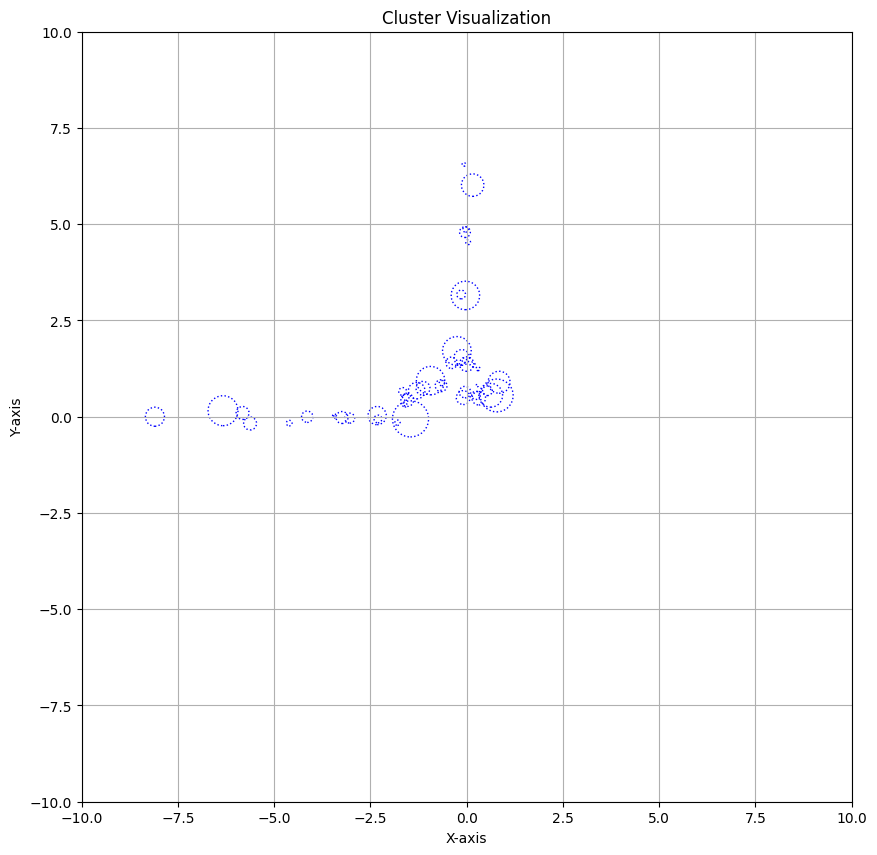

In [77]:
if dim != 2:
    print(f"Dimension {dim} can be visualized using cluster_visualization2D.")
"""Visualization"""
fig, ax = plt.subplots(figsize=(10,10))
for center,radius in zip(cluster_center,cluster_radius):
    circle = plt.Circle(center, radius, fill=False, linestyle='dotted', edgecolor='b')
    ax.add_artist(circle)

# Set axis limits
ax.set_xlim(boundaries[0])
ax.set_ylim(boundaries[1])
# ax.autoscale_view()

# # Add labels (optional)
# for i, center in cluster_center.items():
#     ax.text(center[0], center[1], f'Cluster {i+1}', ha='center', va='bottom')

# Add a title and labels (optional)
ax.set_title('Cluster Visualization')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')  # Make the aspect ratio equal
plt.grid(True)
plt.show()

In [78]:
answ = np.array([[-6.437160, 0.155348],
                 [-0.932122, 1.067870],
                 [-0.155283, 6.439840],
                 [0.163333, 6.122430],
                 [0.667121, 0.690103],
                 [-6.117110, -0.163476]])

possible_cluster_id = []
for i in range (len(cluster_center)):
    for j in range (len(answ)):
        ddist = np.linalg.norm(cluster_center[i]-answ[j])
        if ddist <= cluster_radius[i]:
            possible_cluster_id.append([i,j])
            print(f'cluster_center[{i}] x answ[{j}]')


cluster_center[0] x answ[1]
cluster_center[1] x answ[4]
cluster_center[3] x answ[0]
cluster_center[3] x answ[5]
cluster_center[9] x answ[4]
cluster_center[11] x answ[3]
cluster_center[28] x answ[4]


# SDDE Evaluation

In [79]:
rx = np.random.randint(0,100)
print(rx)

36


In [80]:
archive = []
for i in range (len(cluster_center)):
    boundsA = np.array([cluster_center[i]-cluster_radius[i],cluster_center[i]+cluster_radius[i]])
    # archiveA = dl.differensial_evolution(number_of_population=m,
    #                                      objective_function=root_objective_function,
    #                                      boundaries=boundsA,
    #                                      dimension=dim,
    #                                      gen_max=k_max,
    #                                      mutation_factor=mutation_factor,
    #                                      crossover_rate=crossover_rate,
    #                                      seed=seed)
    root, root_score = dl.differensial_evolution(objective_func=root_objective_function,
                                                 population_size=m,
                                                 boundaries=boundsA, 
                                                 gen_max=k_max, 
                                                 mutation_factor=mutation_factor, 
                                                 crossover_rate=crossover_rate,
                                                 seed=seed,
                                                 print_gen = False,
                                                 history = False)
    archive.append(root)
    print(f'\n====== Cluster {i} ======\n')
    print(f'Roots = {archive}')
archive


====== Cluster 0 ======

Roots = [array([-0.93212205,  1.06787439])]

====== Cluster 1 ======

Roots = [array([-0.93212205,  1.06787439]), array([0.35443974, 1.07122848])]

====== Cluster 2 ======

Roots = [array([-0.93212205,  1.06787439]), array([0.35443974, 1.07122848]), array([0.44761412, 0.59444151])]

====== Cluster 3 ======

Roots = [array([-0.93212205,  1.06787439]), array([0.35443974, 1.07122848]), array([0.44761412, 0.59444151]), array([-6.1171134 , -0.16347552])]

====== Cluster 4 ======

Roots = [array([-0.93212205,  1.06787439]), array([0.35443974, 1.07122848]), array([0.44761412, 0.59444151]), array([-6.1171134 , -0.16347552]), array([0.6671212, 0.6901032])]

====== Cluster 5 ======

Roots = [array([-0.93212205,  1.06787439]), array([0.35443974, 1.07122848]), array([0.44761412, 0.59444151]), array([-6.1171134 , -0.16347552]), array([0.6671212, 0.6901032]), array([0.6671212, 0.6901032])]

====== Cluster 6 ======

Roots = [array([-0.93212205,  1.06787439]), array([0.354439

[array([-0.93212205,  1.06787439]),
 array([0.35443974, 1.07122848]),
 array([0.44761412, 0.59444151]),
 array([-6.1171134 , -0.16347552]),
 array([0.6671212, 0.6901032]),
 array([0.6671212, 0.6901032]),
 array([-6.43716259,  0.15534788]),
 array([-3.18291286e+00, -1.63150290e-04]),
 array([0.54931611, 0.80108673]),
 array([0.3167634, 0.9332366]),
 array([0.6671212, 0.6901032]),
 array([0.6671212, 0.6901032]),
 array([0.6671212, 0.6901032]),
 array([-1.55738128,  0.41291329]),
 array([-3.09834968, -0.09277344]),
 array([-5.79301417, -0.16812593]),
 array([0.6671212, 0.6901032]),
 array([-5.98832667, -0.16630111]),
 array([-1.64452626,  0.26540814]),
 array([-1.59212447,  0.36416145]),
 array([-1.46770862, -0.08684146]),
 array([-1.60831612,  0.04210571]),
 array([0.48989566, 0.7879707 ]),
 array([0.6671212, 0.6901032]),
 array([-3.18291286e+00, -1.63153181e-04]),
 array([0.6671212, 0.6901032]),
 array([0.6671212, 0.6901032]),
 array([-3.18291286e+00, -1.63149654e-04]),
 array([0.556639

In [81]:
aa = np.array([[1,2],[3,1],[3,1],[9,7]])
aa_id = np.arange(aa.shape[0])
id_del = 2
aa_no_id = np.delete(aa_id,id_del,axis=0)
aa[aa_no_id]

array([[1, 2],
       [3, 1],
       [9, 7]])

In [82]:
if dim == 1:
    list_criteria = [element for sublist in archive for element in sublist] #convert from 2D array into 1D array
else:
    list_criteria = archive
eligible_roots = np.array([x for x in list_criteria if (root_objective_function(x))<-1+epsilon])
eligible_roots

array([[-0.93212205,  1.06787439],
       [-6.1171134 , -0.16347552],
       [ 0.6671212 ,  0.6901032 ],
       [ 0.6671212 ,  0.6901032 ],
       [-6.43716259,  0.15534788],
       [ 0.6671212 ,  0.6901032 ],
       [ 0.6671212 ,  0.6901032 ],
       [ 0.6671212 ,  0.6901032 ],
       [ 0.6671212 ,  0.6901032 ],
       [ 0.6671212 ,  0.6901032 ],
       [ 0.6671212 ,  0.6901032 ],
       [ 0.6671212 ,  0.6901032 ],
       [ 0.6671212 ,  0.6901032 ],
       [ 0.6671212 ,  0.6901032 ],
       [ 0.6671212 ,  0.6901032 ],
       [ 0.6671212 ,  0.6901032 ],
       [ 0.6671212 ,  0.6901032 ],
       [ 0.6671212 ,  0.6901032 ],
       [ 0.6671212 ,  0.6901032 ]])

In [83]:
id_duplicated_roots = []
for i in range(len(eligible_roots)):
    for j in range (i+1,len(eligible_roots)):
        if np.linalg.norm(eligible_roots[i]-eligible_roots[j])<delta:
            id_duplicated_roots.append([i,j])
id_duplicated_roots = np.unique(id_duplicated_roots,axis=0)
deselected_id_duplicated_roots = []
for i in range (len(id_duplicated_roots)):
    root_a = root_objective_function(eligible_roots[id_duplicated_roots[i][0]])
    root_b = root_objective_function(eligible_roots[id_duplicated_roots[i][1]])
    if root_a<=root_b:
        id_duplicated_root = id_duplicated_roots[i][1]
    else:
        id_duplicated_root = id_duplicated_roots[i][0]
    deselected_id_duplicated_roots.append(id_duplicated_root)

if deselected_id_duplicated_roots:
    unique_roots = np.ones(len(eligible_roots),dtype=bool)
    unique_roots[deselected_id_duplicated_roots] = False
    final_root = eligible_roots[unique_roots]
else:
    final_root = eligible_roots

final_root

array([[-0.93212205,  1.06787439],
       [-6.1171134 , -0.16347552],
       [ 0.6671212 ,  0.6901032 ],
       [-6.43716259,  0.15534788]])